In [1]:
#  IMPORTS

import pandas as pd
from metrics.energy_estimation import MetricsEE
from metrics.event_detection import MetricsED
from metrics.hybrid_metrics import HybridMetrics

In [32]:
# Load XGBoost GT and pred

# GT
xgb_gt = pd.read_csv('results/xgboost/uk_all/test/gt.csv',
                     index_col='datetime', parse_dates=True)

# Pred
xgb_pred = {}
for i in range(1, 11):
    temp_results = pd.read_csv('results/xgboost/uk_all/test/Model {:02d}.csv'.format(i), 
                               index_col='datetime', parse_dates=True)
    
    xgb_pred['Model {:02d}'.format(i)] = temp_results

In [33]:
# TabNet GT and Pred

# GT
tn_gt = pd.read_csv('results/tabnet/uk_all/test/gt.csv',
                    index_col='datetime', parse_dates=True)

# Pred

tn_pred = {}
for i in range(1, 11):
    temp_results = pd.read_csv('results/tabnet/uk_all/test/Model {:02d}.csv'.format(i),
                               index_col='datetime', parse_dates=True)
    
    tn_pred['Model {:02d}'.format(i)] = temp_results

In [34]:
# Aux Function to Load data

import glob

def load_predictions(folder):
    y_true = pd.read_csv('{}/gt.csv'.format(folder), index_col='datetime_utc', parse_dates=True)
    
    dict_pred = {}
    temp_files = glob.glob('{}/Model *.csv'.format(folder))
    for file in temp_files:
        model_name = file.split('\\')[-1].split('.')[0]
        prediction_file = pd.read_csv(file, index_col='datetime_utc', parse_dates=True)
        prediction_file.loc[prediction_file['PV'] < 0] = 0
        dict_pred[model_name] = prediction_file
        
    return y_true, dict_pred


def load_upac(folder):
    # folder should be something like 'results/nn/upac08'
    
    train_gt, train_pred = load_predictions('{}/train'.format(folder))
    val_gt, val_pred = load_predictions('{}/val'.format(folder))
    test_gt, test_pred = load_predictions('{}/test'.format(folder))
    
    gt = {'train': train_gt,
          'val': val_gt,
          'test': test_gt}
    
    pred = {'train': train_pred,
            'val': val_pred,
            'test': test_pred}
    
    return gt, pred
    

def load_algorithm(folder):
    # Create a couple dictionaries for storing the several instances
    gt_dict = {}
    pred_dict = {}
    
    folders = glob.glob(folder)
    for i in np.arange(len(folders)):
        upac_name = folders[i].split('\\')[1]
        temp_gt, temp_pred = load_upac(folders[i])
        gt_dict[upac_name] = temp_gt
        pred_dict[upac_name] = temp_pred
        
    return gt_dict, pred_dict

In [35]:
# Aux Function to help calculate metrics without a mess

def calculate_dictionary_metrics(y, yhat_dictionary):
    metrics_averaged = pd.DataFrame({})
    
    metrics_daily = {}
    metrics_monthly = {}
    
    for model in yhat_dictionary.keys():
        metrics_ee = MetricsEE()
        ee_daily_metrics = metrics_ee.check_metrics(y, yhat_dictionary[model],
                                                    metric_list=['rmse', 'mape', 'cep'],
                                                    interval='Day')
        metrics_daily[model] = ee_daily_metrics
        
        ee_monthly_metrics = metrics_ee.check_metrics(y, yhat_dictionary[model],
                                                      metric_list=['rmse', 'mape', 'cep'],
                                                      interval='Month')
        metrics_monthly[model] = ee_monthly_metrics
        
        temp_df = pd.DataFrame({'RMSE (Daily Average)': np.mean(ee_daily_metrics['pv_power_mw']['rmse']),
                                'RMSE (Monthly Average)': np.mean(ee_monthly_metrics['pv_power_mw']['rmse']),
                                'CEP CX (Daily Average)': np.mean(ee_daily_metrics['pv_power_mw']['cep_cx']),
                                'CEP CX (Monthly Average)': np.mean(ee_monthly_metrics['pv_power_mw']['cep_cx'])},
                               index=[model])
        metrics_averaged = metrics_averaged.append(temp_df)
        
    return metrics_daily, metrics_monthly, metrics_averaged

In [36]:
# Calculate Metrics

xgb_daily, xgb_monthly, xgb_averaged = calculate_dictionary_metrics(xgb_gt,
                                                                    xgb_pred)

tn_daily, tn_monthly, tn_averaged = calculate_dictionary_metrics(tn_gt,
                                                                 tn_pred)

# XGBoost results

In [37]:
xgb_averaged

,RMSE (Daily Average),RMSE (Monthly Average),CEP CX (Daily Average),CEP CX (Monthly Average)
Model 01,0.137284,0.176607,0.960381,0.962769
Model 02,0.137284,0.176607,0.960381,0.962769
Model 03,0.137284,0.176607,0.960381,0.962769
Model 04,0.137284,0.176607,0.960381,0.962769
Model 05,0.137284,0.176607,0.960381,0.962769
Model 06,0.137284,0.176607,0.960381,0.962769
Model 07,0.137284,0.176607,0.960381,0.962769
Model 08,0.137284,0.176607,0.960381,0.962769
Model 09,0.137284,0.176607,0.960381,0.962769
Model 10,0.137284,0.176607,0.960381,0.962769


## TabNet results

In [38]:
tn_averaged

,RMSE (Daily Average),RMSE (Monthly Average),CEP CX (Daily Average),CEP CX (Monthly Average)
Model 01,0.112232,0.140607,0.963179,0.971869
Model 02,0.112308,0.142149,0.969313,0.972104
Model 03,0.110924,0.142028,0.957888,0.966552
Model 04,0.109283,0.137678,0.956026,0.967307
Model 05,0.112947,0.142397,0.957922,0.965171
Model 06,0.111529,0.141123,0.970451,0.974378
Model 07,0.114938,0.144397,0.968945,0.973583
Model 08,0.108761,0.137637,0.973363,0.975840
Model 09,0.110011,0.140218,0.976111,0.976861
Model 10,0.114215,0.146548,0.971514,0.974831


In [206]:
# Add season information to dataframes

def extract_season(df):
    
    date = df.index.month*100 + df.index.day
    df['season'] = (pd.cut(date,[0,321,620,922,1220,1300],
                           labels=['winter','spring','summer','autumn','winter '])
                    #.str.strip()
                   )
    df['season'] = df['season'].str.replace(' ', '')
    df['season'] = df['season'].astype('category')
    
    df['season_int'] = df['season'].cat.codes
    
    return

season_gt = xgb_gt['upac08']['test'].copy(deep=True)
extract_season(season_gt)

xgb_all = xgb_pred['upac08']['test']['Model 01'].copy(deep=True)
extract_season(xgb_all)

xgb_top1 = xgb_pred['upac08_top1']['test']['Model 01'].copy(deep=True)
extract_season(xgb_top1)

tn_all = tn_pred['upac08']['test']['Model 09'].copy(deep=True)
extract_season(tn_all)

tn_top4 = tn_pred['upac08_topk']['test']['Model 09'].copy(deep=True)
extract_season(tn_top4)

tn_top1 = tn_pred['upac08_top1']['test']['Model 09'].copy(deep=True)
extract_season(tn_top1)

In [214]:
# Metric Calculation for each model

def model_season_metrics(gt, pred):
    
    season_daily_metrics = {}
    season_monthly_metrics = {}
    season_averaged_metrics = {}
    
    for season in pred['season'].unique():
        new_gt = gt.loc[gt['season'] == season].drop(['season', 'season_int'], axis=1)
        new_pred = pred.loc[pred['season'] == season].drop(['season', 'season_int'], axis=1)
        
        metrics_ee = MetricsEE()
        ee_daily_metrics = metrics_ee.check_metrics(new_gt, new_pred,
                                                    metric_list=['rmse'],
                                                    interval='Day')
        
        temp_df = pd.DataFrame({'RMSE (Daily Average)': ee_daily_metrics['PV']['rmse'].describe().loc['mean'],
                                'RMSE (Daily Std)' : ee_daily_metrics['PV']['rmse'].describe().loc['std']},
                               index=[0])
        
        season_daily_metrics[season] = ee_daily_metrics
        season_averaged_metrics[season] = temp_df
        
    metrics = {}
    metrics['Daily'] = season_daily_metrics
    metrics['Averaged'] = season_averaged_metrics
    
    return metrics

xgb_all_metrics = model_season_metrics(season_gt, xgb_all)
xgb_top1_metrics = model_season_metrics(season_gt, xgb_top1)

tn_all_metrics = model_season_metrics(season_gt, tn_all)
tn_top4_metrics = model_season_metrics(season_gt, tn_top4)

tn_top1_metrics = model_season_metrics(season_gt, tn_top1)

In [208]:
# Add season information for feature selection models

xgb_corr = xgb_pred['upac08_spearman_ghidayx']['test']['Model 01'].copy(deep=True)
extract_season(xgb_corr)

xgb_var = xgb_pred['upac08_variance']['test']['Model 01'].copy(deep=True)
extract_season(xgb_var)

tn_corr = tn_pred['upac08_spearman_ghidayx']['test']['Model 02'].copy(deep=True)
extract_season(tn_corr)

tn_var = tn_pred['upac08_variance']['test']['Model 08'].copy(deep=True)
extract_season(tn_var)

In [255]:
# Model Metrics for feature selection models

xgb_corr_metrics = model_season_metrics(season_gt, xgb_corr)

xgb_var_metrics = model_season_metrics(season_gt, xgb_var)

tn_corr_metrics = model_season_metrics(season_gt, tn_corr)

tn_var_metrics = model_season_metrics(season_gt, tn_var)

In [257]:
# Put everything on a unified table

metrics_table = {'Overall': best_algo['RMSE (Daily Average)'].values,
                 'Spring': [xgb_all_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            xgb_top1_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            xgb_corr_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            xgb_var_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_all_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_top4_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_top1_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_corr_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0],
                            tn_var_metrics['Averaged']['spring']['RMSE (Daily Average)'].values[0]],
                 'Summer': [xgb_all_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            xgb_top1_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            xgb_corr_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            xgb_var_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_all_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_top4_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_top1_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_corr_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0],
                            tn_var_metrics['Averaged']['summer']['RMSE (Daily Average)'].values[0]],
                 'Autumn': [xgb_all_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            xgb_top1_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            xgb_corr_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            xgb_var_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_all_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_top4_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_top1_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_corr_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0],
                            tn_var_metrics['Averaged']['autumn']['RMSE (Daily Average)'].values[0]],
                 'Winter': [xgb_all_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            xgb_top1_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            xgb_corr_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            xgb_var_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_all_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_top4_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_top1_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_corr_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0],
                            tn_var_metrics['Averaged']['winter']['RMSE (Daily Average)'].values[0]]}

metrics_table = pd.DataFrame(metrics_table, index=['XGBoost', 'XGBoost Top 1', 'XGBoost Corr', 'XGBoost Variance',
                                                   'TabNet', 'TabNet Top 4', 'TabNet Top 1', 'TabNet Corr', 'TabNet Variance'])
metrics_table

,Overall,Spring,Summer,Autumn,Winter
XGBoost,433.873424,482.358689,416.215553,423.377781,415.103459
XGBoost Top 1,425.731192,432.499751,416.211796,423.594992,430.899026
XGBoost Corr,509.597540,528.390224,523.265923,496.974653,489.951270
XGBoost Variance,1023.839773,1168.640980,931.213302,890.511533,1107.854524
TabNet,338.386564,358.764108,325.473623,347.393767,322.926408
TabNet Top 4,331.788760,354.781688,283.521094,340.874931,349.465443
TabNet Top 1,398.423794,407.603881,388.572130,395.937411,401.938010
TabNet Corr,398.624492,410.160494,394.680189,392.924077,397.031578
TabNet Variance,988.824651,1068.513826,1140.747823,843.815565,899.992008


In [258]:
# Metric differences - XGBoost

xgb_changes = metrics_table.copy(deep=True)
xgb_changes = xgb_changes.iloc[:4]

xgb_changes = xgb_changes / xgb_changes.iloc[0]
xgb_changes[1:] -= 1
xgb_changes[1:] *= -100

xgb_changes

,Overall,Spring,Summer,Autumn,Winter
XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000
XGBoost Top 1,1.876638,10.336486,0.000903,-0.051304,-3.805212
XGBoost Corr,-17.453043,-9.543009,-25.719935,-17.383263,-18.031122
XGBoost Variance,-135.976604,-142.276341,-123.733422,-110.334971,-166.886363


In [259]:
# Metric differences - TabNet

tn_changes = metrics_table.copy(deep=True)
tn_changes = tn_changes.iloc[4:]

tn_changes = tn_changes / tn_changes.iloc[0]
tn_changes[1:] -= 1
tn_changes[1:] *= -100

tn_changes

,Overall,Spring,Summer,Autumn,Winter
TabNet,1.000000,1.000000,1.000000,1.000000,1.000000
TabNet Top 4,1.949783,1.110038,12.889686,1.876498,-8.218292
TabNet Top 1,-17.742203,-13.613339,-19.386673,-13.973666,-24.467371
TabNet Corr,-17.801513,-14.325956,-21.263341,-13.106254,-22.948006
TabNet Variance,-192.217468,-197.831863,-250.488563,-142.898879,-178.698795


In [175]:
# Other feature selection methods

xgbcorr_u08_test_daily, xgbcorr_u08_test_monthly, xgbcorr_u08_test_averaged = calculate_dictionary_metrics(xgb_gt['upac08_spearman_ghidayx']['test'],
                                                                                                           xgb_pred['upac08_spearman_ghidayx']['test'])

xgbvar_u08_test_daily, xgbvar_u08_test_monthly, xgbvar_u08_test_averaged = calculate_dictionary_metrics(xgb_gt['upac08_variance']['test'],
                                                                                                        xgb_pred['upac08_variance']['test'])

tncorr_u08_test_daily, tncorr_u08_test_monthly, tncorr_u08_test_averaged = calculate_dictionary_metrics(tn_gt['upac08_spearman_ghidayx']['test'],
                                                                                                        tn_pred['upac08_spearman_ghidayx']['test'])

tnvar_u08_test_daily, tnvar_u08_test_monthly, tnvar_u08_test_averaged = calculate_dictionary_metrics(tn_gt['upac08_variance']['test'],
                                                                                                     tn_pred['upac08_variance']['test'])

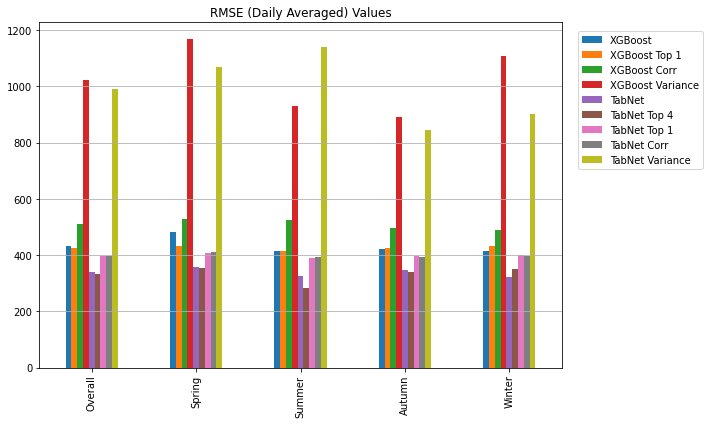

In [273]:
metrics_table.transpose().plot(kind='bar', figsize=(8, 6))

plt.title('RMSE (Daily Averaged) Values')

plt.tight_layout()

plt.legend(bbox_to_anchor=(1.28, 0.99))

plt.grid(axis='y')

plt.show()

In [46]:
tn_averaged

,RMSE (Daily Average),RMSE (Monthly Average),CEP CX (Daily Average),CEP CX (Monthly Average)
Model 01,335.708325,366.498774,0.806585,0.823553
Model 02,341.499765,371.855891,0.800584,0.822391
Model 03,341.824834,373.692137,0.795311,0.818207
Model 04,336.220376,366.589985,0.816574,0.833165
Model 05,345.463044,375.565231,0.798017,0.816461
Model 06,337.517371,367.051262,0.801205,0.820529
Model 07,334.585828,363.602489,0.800959,0.822297
Model 08,340.153347,370.486398,0.791368,0.814914
Model 09,339.990552,369.982621,0.805237,0.823995
Model 10,337.309055,367.854205,0.790033,0.811981
